In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming,euclidean
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
import seaborn as sns
import datetime, nltk, warnings

import matplotlib.cm as cm
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
font = {'size'   : 22}
mpl.rc('font', **font)
%matplotlib inline

In [2]:
font = {'size'   : 22}
mpl.rc('font', **font)

In [3]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters): 
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

In [4]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [5]:
df_cust_type = pd.read_csv('TB_thang89_cluster.csv',dtype={'msisdn': str})[['msisdn','request_date','customer_type']]
df_cust_type = df_cust_type.sort_values(by=['msisdn','request_date']).groupby('msisdn')['customer_type'].agg(['last'])

In [6]:
df_cust_type[df_cust_type['last']==20].index

Index(['84012213244', '842223503222', '84228890729', '84233800224',
       '84234836005', '84238539258', '84239106117', '84252951314',
       '842566514088', '84257217185',
       ...
       '84996578305', '84996591449', '84996782999', '84997000939',
       '84997085296', '84997098686', '84997313686', '84997498587',
       '84997666939', '84997739149'],
      dtype='object', name='msisdn', length=224419)

In [2]:
df = pd.read_csv('ViettelCustSegment_final_2.csv')

# df_cl = pd.read_csv(r'KPro_params\real_cl_list_3.csv')
# df_sil = pd.read_csv(r'KPro_params\real_silhoutte_list_3.csv')
# df = df.drop(columns = 'Unnamed: 0')
# df_cl = df_cl.drop(columns = 'Unnamed: 0')
# df_sil = df_sil.drop(columns = 'Unnamed: 0')
# df['cluster'] = df_cl
# df['goi'] = df['msisdn'].isin(df_cust_type[df_cust_type['last']==20].index).astype(int)

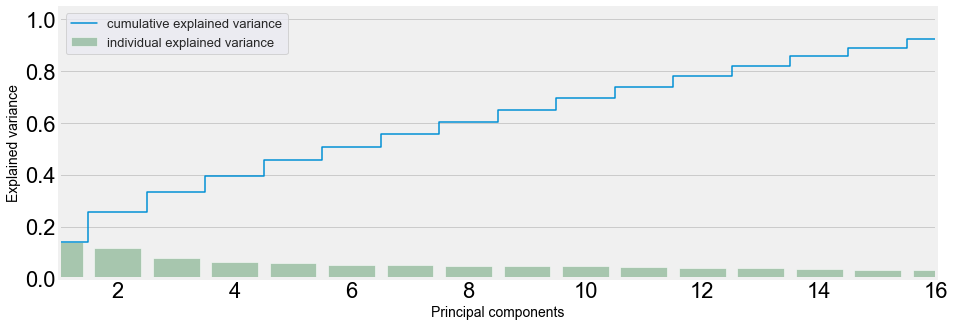

In [8]:
X = df.iloc[:,1:].drop(columns = 'cluster').values
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_X)
pca_samples = pca.transform(scaled_X)

fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(scaled_X.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,scaled_X.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 15)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)

Principal Component Analysis demonstrate the total variance is not equally contributed by different features. The percentage of each features to total variance is showned in the below table

In [9]:
pd.DataFrame(pca.explained_variance_ratio_ * 100,index = df.iloc[:,1:].drop(columns = 'cluster').columns )

,0
sum_gdtc,13.961423
count_gdtc,11.769100
max_gdtc,7.745190
recency,6.174229
hypothetical_trans_amount,5.872384
usage_length_in_days,5.282043
card_status,4.961864
error_per_day,4.723078
error_req_percentage,4.695530
last_code=error,4.570249


- msisdn: sđt khách hàng
- sum_gdtc: tổng giá trị các gdtc thành công
- max_gdtc: giá trị của gdtc thành công lớn nhất
- recency: số ngày từ giao dịch cuối cùng
- usage_length_in_days: số ngày từ giao dịch cuối đến đầu
- card_status: 1 nếu KH đã liên kết thẻ, 0 nếu ngược lại
- error_per_day: tổng số lỗi KH gặp / tổng số ngày KH sử dụng
- error_req_percentage: tổng giao dịch lỗi/ tổng số giao dịch
- last_code = error: 1 nếu giao dịch cuối của KH gặp lỗi, 0 otherwise
- last_error_sodu, mapin, cachdung: phân chia các loại lỗi phổ biến
- tt_diennuoc, taichinh, muasam, vienthong: 1 nếu KH đã sử dụng dịch vụ điện nước/tài chính/mua sắm/viễn thông. 0 otherwise
- gender: giới tính
- pin_lock: 1 nếu mã pin KH bị lock, 0 otherwise
- pin_ok, 1 nếu mã pin KH bình thường, 0 otherwise
- gói: 1 nếu KH thuộc gói 3, 0 nếu KH thuộc gói 1

# N_Cluster = 3

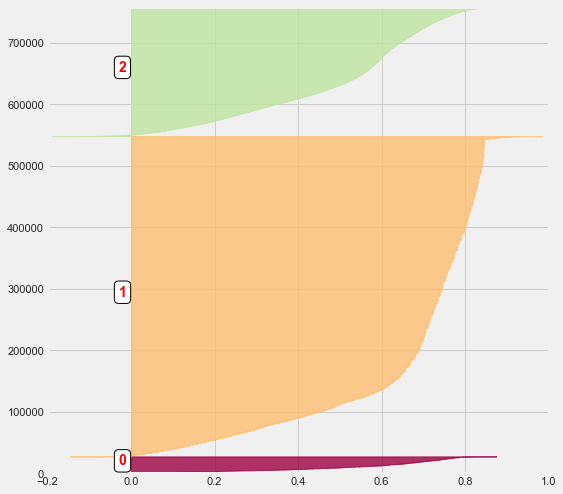

In [10]:
graph_component_silhouette(3, [-0.2, 1], len(df), np.array(df_sil), np.array(df_cl))

For any datapoints corresponding to negative silhoutte score, its cluster will be manually changed to the cluster corresponding to closest K-Protype distance

In [11]:
df['cluster'].value_counts().sort_index()

0     27456
1    520555
2    210146
Name: cluster, dtype: int64

In [12]:
n_clusters = 3
clust_df_3 = pd.DataFrame()
for i in range(0,n_clusters):
    centroid = pd.DataFrame(df[df['cluster'] == i].mean()).T
    clust_df_3 = clust_df_3.append(centroid)
clust_df_3 = clust_df_3.set_index('cluster')
clust_df_3.head()    

,sum_gdtc,count_gdtc,max_gdtc,recency,hypothetical_trans_amount,usage_length_in_days,card_status,error_per_day,error_req_percentage,last_code=error,...,last_error_mapin,last_error_cachdung,tt_diennuoc,tt_taichinh,tt_muasam,tt_vienthong,gender,pin_lock,pin_ok,goi
cluster,,,,,,,,,,,,,,,,,,,,,
0.0,1.909997e+08,24.962995,4.446373e+07,18.572516,5.215063e+08,58.136109,0.114583,0.138824,0.054876,0.029902,...,0.003169,0.000401,0.126821,0.021962,0.048295,0.267446,0.445986,0.000692,0.995374,0.034018
1.0,4.822857e+05,0.336512,1.995171e+05,74.434822,1.708411e+06,3.662739,0.032621,0.475425,0.078906,0.161357,...,0.037679,0.016751,0.012613,0.001885,0.020922,0.193219,0.057662,0.002130,0.973667,0.007200
2.0,7.419985e+06,6.080554,1.944290e+06,16.940974,2.013753e+07,60.976079,0.185523,0.105557,0.182143,0.238639,...,0.080144,0.011430,0.139465,0.016522,0.096500,0.517026,0.194465,0.001071,0.991639,0.023046


In [13]:
clust_df_3.to_csv(r"C:\Users\os_sonnh1\Downloads\pythonscript\REALWORK\clust_df_3.csv")

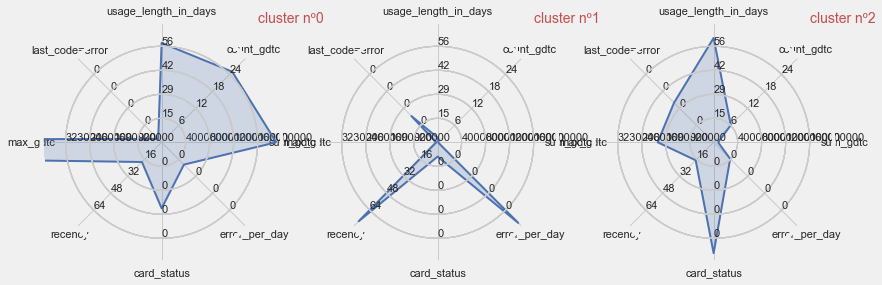

In [14]:
n_clusters = 3
fig = plt.figure(figsize=(10,12))

attributes = ['sum_gdtc', 'count_gdtc', 'usage_length_in_days', 'last_code=error', 'max_gdtc', 'recency', 'card_status', 'error_per_day']
ranges = [[0, 200000000], [0.01, 30], [1, 70], [0.01, 0.5], [150000, 4000000], [0, 80], [0.01, 0.2], [0.01,0.5 ]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(clust_df_3.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

In [15]:
df.describe()

,sum_gdtc,count_gdtc,max_gdtc,recency,hypothetical_trans_amount,usage_length_in_days,card_status,error_per_day,error_req_percentage,last_code=error,...,last_error_cachdung,tt_diennuoc,tt_taichinh,tt_muasam,tt_vienthong,gender,pin_lock,pin_ok,cluster,goi
count,7.581570e+05,758157.000000,7.581570e+05,758157.000000,7.581570e+05,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000,...,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000,758157.000000
mean,9.304701e+06,2.820473,2.286124e+06,56.475669,2.564063e+07,21.521560,0.077971,0.360715,0.106651,0.178017,...,0.014684,0.051910,0.006669,0.042862,0.285660,0.109644,0.001785,0.979434,1.240966,0.012563
std,1.031464e+08,22.087409,9.088896e+06,31.923823,4.563666e+08,29.794951,0.268126,9.103206,0.173441,0.382527,...,0.120286,0.221846,0.081390,0.202546,0.451728,0.312445,0.042207,0.141925,0.505302,0.111380
min,0.000000e+00,0.000000,0.000000e+00,0.000000,-1.289000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,30.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,0.000000e+00,0.000000,0.000000e+00,60.000000,1.940000e+04,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,5.000000e+04,1.000000,5.000000e+04,82.000000,4.165000e+05,42.000000,0.000000,0.111111,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000
max,5.895240e+10,9325.000000,1.000000e+08,109.000000,1.274840e+11,109.000000,1.000000,1969.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000


# N_Cluster = 4

In [24]:
df_cl_4 = pd.read_csv(r'KPro_params\real_cl_list_4.csv')
df_cl_4['0'].value_counts()

2    520474
3    210131
0     27489
1        63
Name: 0, dtype: int64

n_clusters = 4 result in second clusters has too few data points. This result therefore will not be further analyzed

# N_Cluster = 5

In [25]:
df_cl_5 = pd.read_csv(r'KPro_params\real_cl_list_5.csv')
df_cl_5['0'].value_counts()

2    520292
4    209230
1     28405
3       168
0        62
Name: 0, dtype: int64

n_clusters = 5 result in second clusters has too few data points. This result therefore will not be further analyzed

# N_Cluster = 6

In [3]:
df_cl_6 = pd.read_csv(r'KPro_params\real_cl_list_6.csv')
df_cl_6['0'].value_counts().sort_index()

0       168
1        62
2     26264
3    175189
4    101761
5    454713
Name: 0, dtype: int64

In [4]:
# df_sil_6 = pd.read_csv(r'KPro_params\real_silhoutte_list_6.csv')
df_cl_6 = df_cl_6.drop(columns = 'Unnamed: 0')
# df_sil_6 = df_sil_6.drop(columns = 'Unnamed: 0')
df['cluster_6'] = df_cl_6

In [6]:
pd.DataFrame(df[df['cluster_6']==5]['msisdn']).to_csv(r"C:\Users\os_sonnh1\Downloads\pythonscript\REALWORK\KPro_params\msisdn_cluster5.csv")

In [19]:
n_clusters = 6
clust_df_6 = pd.DataFrame()
for i in range(0,n_clusters):
    print(i)
    centroid = pd.DataFrame(df[df['cluster_6'] == i].mean()).T
    clust_df_6 = clust_df_6.append(centroid)
clust_df_6 = clust_df_6.set_index('cluster_6')
clust_df_6['user_count'] =  df_cl_6['0'].value_counts().sort_index()

0
1
2
3
4
5


In [ ]:
clust_df_6.to_csv(r"C:\Users\os_sonnh1\Downloads\pythonscript\REALWORK\clust_df_6.csv")

In [22]:
clust_df_6

,card_status,cluster,count_gdtc,error_per_day,error_req_percentage,gender,goi,hypothetical_trans_amount,last_code=error,last_error_cachdung,...,pin_lock,pin_ok,recency,sum_gdtc,tt_diennuoc,tt_muasam,tt_taichinh,tt_vienthong,usage_length_in_days,user_count
cluster_6,,,,,,,,,,,,,,,,,,,,,
0.0,0.244048,0.000000,603.880952,1.022417,0.060135,0.339286,0.023810,2.035429e+10,0.035714,0.000000,...,0.005952,0.934524,2.214286,2.669079e+09,0.160714,0.166667,0.047619,0.785714,92.678571,168
1.0,0.000000,0.983871,0.080645,894.834677,0.997015,0.000000,0.000000,2.261097e+06,0.000000,0.000000,...,0.000000,1.000000,77.758065,1.507565e+06,0.000000,0.000000,0.000000,0.016129,1.951613,62
2.0,0.109085,0.003503,20.076074,0.108022,0.055149,0.448142,0.033316,3.928658e+08,0.029927,0.000305,...,0.000647,0.995926,19.253313,1.758139e+08,0.126142,0.045119,0.020332,0.257767,56.943497,26264
3.0,0.216589,1.982693,7.544926,0.070840,0.106954,0.214380,0.026006,2.468952e+07,0.123781,0.003996,...,0.000925,0.992380,14.121828,9.933258e+06,0.124848,0.108260,0.019585,0.562221,64.232623,175189
4.0,0.031849,1.360020,0.219514,1.218410,0.460367,0.055660,0.005424,7.302616e+06,0.786529,0.092334,...,0.001867,0.991549,56.928116,1.476171e+05,0.092688,0.043425,0.002290,0.318639,20.523757,101761
5.0,0.033038,1.000523,0.363966,0.172841,0.030246,0.061751,0.007781,1.392705e+06,0.071364,0.002263,...,0.002162,0.970797,74.859331,5.126997e+05,0.010363,0.017369,0.001869,0.173191,3.219831,454713


In [23]:
1.392705e+06

1392705.0

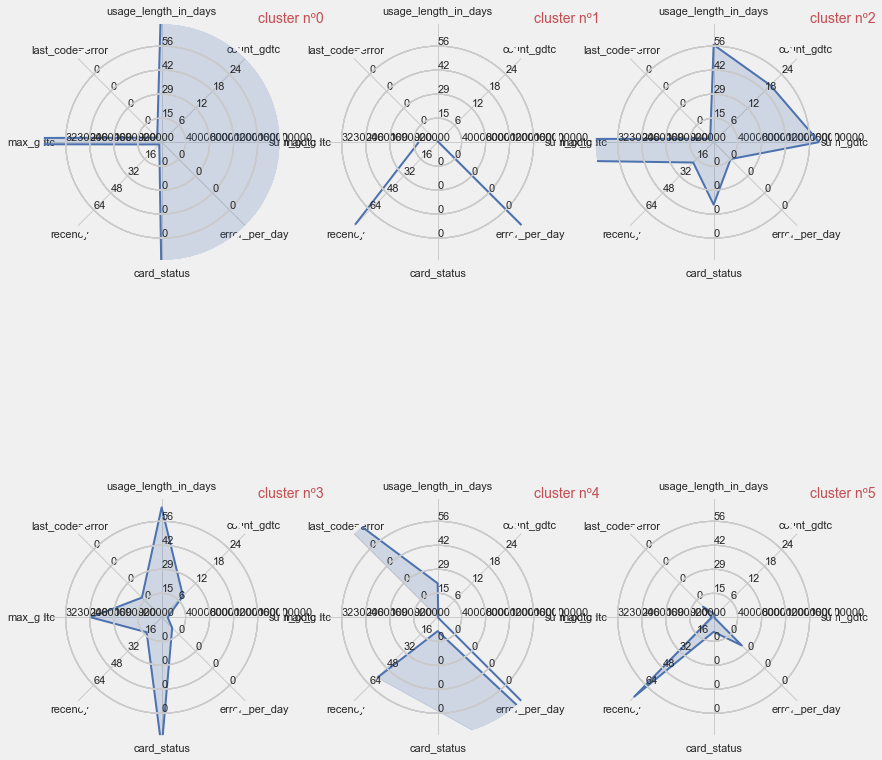

In [21]:
n_clusters = 6
fig = plt.figure(figsize=(10,12))

attributes = ['sum_gdtc', 'count_gdtc', 'usage_length_in_days', 'last_code=error', 'max_gdtc', 'recency', 'card_status', 'error_per_day']
ranges = [[0, 200000000], [0.01, 30], [1, 70], [0.01, 0.5], [150000, 4000000], [0, 80], [0.01, 0.2], [0.01,0.5 ]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(clust_df_6.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

# N_Cluster = 7


In [ ]:
# df_cl_7 = pd.read_csv(r'KPro_params\real_cl_list_7.csv')
df_cl_7.T.reset_index()[0].value_counts()

In [ ]:
df_cl_7 = df_cl_7.T.reset_index().drop(columns = 'index')

In [ ]:
# df_sil_7 = pd.read_csv(r'KPro_params\real_silhoutte_list_7.csv')
# # df_cl_7 = df_cl_7.drop(columns = 'Unnamed: 0')
# df_sil_7 = df_sil_7.drop(columns = 'Unnamed: 0')
df['cluster_7'] = df_cl_7

In [ ]:
n_clusters = 7
clust_df_7 = pd.DataFrame()
for i in range(0,n_clusters):
    print(i)
    centroid = pd.DataFrame(df[df['cluster_7'] == i].mean()).T
    clust_df_7 = clust_df_7.append(centroid)
clust_df_7 = clust_df_7.set_index('cluster_7')


In [ ]:
df['cluster_7'].value_counts()

In [ ]:
n_clusters = 7
fig = plt.figure(figsize=(10,12))

attributes = ['sum_gdtc', 'count_gdtc', 'usage_length_in_days', 'last_code=error', 'max_gdtc', 'recency', 'card_status', 'error_per_day']
ranges = [[0, 200000000], [0.01, 30], [1, 70], [0.01, 0.5], [150000, 4000000], [0, 80], [0.01, 0.2], [0.01,0.5 ]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(clust_df_7.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 